In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [29]:
import IPython
import IPython.display
from pathlib import Path
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import matplotlib.pyplot as plt

comp_dir = Path('../input/store-sales-time-series-forecasting')

In [30]:
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'], #, 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
       # 'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

In [31]:
print('store_sales: \n', store_sales.shape)
display(store_sales.head())
mean_by_family_all_years = store_sales.groupby(['family', 'date']).mean()
mean_by_family_all_years = mean_by_family_all_years.unstack('family')['sales']
print(mean_by_family_all_years.shape)
mean_by_family_all_years.head()

store_sales: 
 (3000888, 1)


sales
store_nbr family     date             
1         AUTOMOTIVE 2013-01-01    0.0
                     2013-01-02    2.0
                     2013-01-03    3.0
                     2013-01-04    3.0
                     2013-01-05    5.0

(1684, 33)


family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.000000,0.0,0.037037,15.000000,0.0,3.344241,0.0,3.444444,2.648148,1.316481,...,0.0,2.051870,0.462963,0.0,0.0,0.789574,0.700870,0.0,0.0,0.000000
2013-01-02,4.722222,0.0,3.833333,1335.036987,0.0,486.042938,0.0,1382.018555,432.981476,291.750000,...,0.0,386.508606,318.592590,0.0,0.0,258.812683,98.853928,0.0,0.0,28.273148
2013-01-03,2.981482,0.0,2.314815,964.907410,0.0,341.786682,0.0,1035.055542,333.351837,206.897308,...,0.0,307.359222,232.740738,0.0,0.0,197.673965,66.507187,0.0,0.0,20.265018
2013-01-04,3.129630,0.0,2.462963,1003.092590,0.0,309.666077,0.0,964.148132,336.074066,187.837204,...,0.0,400.480804,209.314819,0.0,0.0,199.491013,82.832703,0.0,0.0,23.946686
2013-01-05,6.333333,0.0,3.537037,1441.074097,0.0,414.217804,0.0,1298.666626,427.444458,254.350830,...,0.0,386.649841,311.462952,0.0,0.0,249.537201,107.964317,0.0,0.0,23.067352


## Time features

In [32]:
df_target_mean_2017 =  mean_by_family_all_years.loc['2017']

fourier = CalendarFourier(freq="M", order=4) 
dp = DeterministicProcess(
    index=df_target_mean_2017.index,
    constant=True,
    order=1,
    # YOUR CODE HERE
    seasonal=True, 
    additional_terms=[fourier],
    drop=True,
)
x_base =  dp.in_sample()
x_base['new_year'] = (x_base.index.dayofyear == 1)*1.0
x_base.shape

(227, 17)

## Models

In [33]:
# machine learning model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import backend as K

## Metrics
mse_metric = tf.keras.metrics.MeanSquaredError()
mae_metric = tf.keras.metrics.MeanAbsoluteError()

tf.random.set_seed(3)

from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing

#hyper parameter search
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args
import gc

In [34]:
## Dataset
def preprocess(x, y):
    return x, y
    
def make_dataset(feature, y, batch_size=512, is_training=True):
    ds = tf.data.Dataset.from_tensor_slices((feature, y))
    ds = ds.map(preprocess)
    if is_training:
        ds = ds.shuffle(3*batch_size) #256
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds

def compute_metric_by_batch(model, ds):
    metrics_res = []
    i = 0
    mse_metric.reset_states()
    mae_metric.reset_states()
    for x_batch, y_batch in iter(ds):        
        y_pred = model.predict_on_batch(x_batch) 
        mse_metric.update_state(y_batch, y_pred)
        mae_metric.update_state(y_batch, y_pred)   
        
        i += 1        
    gc.collect()        
    return np.round(mse_metric.result().numpy(), 4), np.round(mae_metric.result().numpy(), 4)

def define_ffnn_model(input_shape, output_shape, dict_parameters):        
    features_inputs = tf.keras.Input((input_shape), dtype=tf.float16)
    units = dict_parameters['units']
    dropout = dict_parameters['dropout']
    rate_var_units = dict_parameters['rate_var_units']
    rate_var_drop = dict_parameters['rate_var_drop']
    i = 0
    for hidden in range(dict_parameters['hidden']):    
        if i == 0:
            x = layers.Dense(units, kernel_regularizer="l2")(features_inputs)
        else:
            x = layers.Dense(units, kernel_regularizer="l2")(x) 
            
        x = layers.Activation(dict_parameters['activation'])(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout)(x)

        units = int(units*rate_var_units)
        dropout = int(dropout*rate_var_drop)
        i += 1

    output = layers.Dense(output_shape)(x)
    model = tf.keras.Model(inputs=[features_inputs], outputs=[output]) 
    
    return model

In [35]:
## Automatic parameters search using SKOPT
def training_model(model, train_ds, valid_ds, num_epochs, hp_parameters_model, eval_config, num_partition):
    list_callbacks = []
    early_stop = tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')
    list_callbacks.append(early_stop) 
    if eval_config['save_model']:
        checkpoint = tf.keras.callbacks.ModelCheckpoint(eval_config['name_model']+str(num_partition), save_best_only=True, 
                                                        save_weights_only=True,
                                                        restore_best_weights=True, 
                                                        monitor='val_mse',  mode="min")
        list_callbacks.append(checkpoint)

    ### Optimization ###
    optimizer = tf.optimizers.Adam(hp_parameters_model['learning_rate']) #0.00001    

    ### metrics
    metrics = ['mse', "mae"]

    ### model compile and fit ###
    model.compile(optimizer=optimizer, loss='mse', metrics=metrics)    

    history = model.fit(train_ds, epochs=num_epochs, validation_data=valid_ds, 
                        callbacks=list_callbacks) #callbacks=[early_stop, checkpoint])    
    return model, history

def show_curves(history):                 
    df_history = pd.DataFrame(history.history)    
    df_history = df_history.set_index(np.arange(df_history.shape[0]))    
    fig, ax = plt.subplots(1, 3, figsize=(10,5))
    df_history[['loss', 'val_loss']].plot(ax=ax[0])
    df_history[['mse', 'val_mse']].plot(ax=ax[1])
    df_history[['mae', 'val_mae']].plot(ax=ax[2])                

def compute_metrics(model, train_ds, valid_ds):
    
    mse_train, mae_train = compute_metric_by_batch(model, train_ds)
    mse_val, mae_val = compute_metric_by_batch(model, valid_ds)    

    print("------------------------ ")                        
    print('rmse_train:',np.sqrt(mse_train), ' mae_train:', mae_train)
    print('rmse_val:',np.sqrt(mse_val), ' mae_val:',mae_val)            
    print("------------------------ ")          
    return {'rmse':np.sqrt(mse_train), 'mae':mae_train}, {'rmse':np.sqrt(mse_val), 'mae':mae_val}


def training_process(x_train, y_train, x_val, y_val, input_shape, output_shape, batch_size,
                     hp_parameters_model, is_evaluation=False, num_partition=1):
    
    list_callbacks = []
    
    ## Read data           
    scaler_train =  preprocessing.StandardScaler()    
    if scaler_train is not None:
        data_for_train = scaler_train.fit_transform(x_train.values)
        data_for_val = scaler_train.transform(x_val.values)
    else:
        data_for_train = x_train.values
        data_for_val = x_val.values

    train_ds = make_dataset(data_for_train,    
                            y_train.values,
                            batch_size=batch_size,
                            is_training=True)            
    
    valid_ds = make_dataset(data_for_val,    
                            y_val.values,
                            batch_size=batch_size,
                            is_training=False)          
    gc.collect() 

    ## Read the model
    model = define_ffnn_model(input_shape, output_shape, hp_parameters_model)
    
    ##Training
    early_stop = tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')   
    list_callbacks.append(early_stop) 
    if is_evaluation:
        checkpoint = tf.keras.callbacks.ModelCheckpoint('final_model', save_best_only=True, 
                                                        save_weights_only=True,
                                                        restore_best_weights=True, 
                                                        monitor='val_mse',  mode="min")
        list_callbacks.append(checkpoint)
    

    ### Optimization ###
    optimizer = tf.optimizers.Adam(hp_parameters_model['learning_rate'])
    
    metrics = ['mse', "mae"]

    ### model compile and fit ###
    model.compile(optimizer=optimizer, loss='mse', metrics=metrics)    
    history = model.fit(train_ds, epochs=num_epochs, validation_data=valid_ds, 
                        callbacks=list_callbacks)            

    if not is_evaluation:
        IPython.display.clear_output()
    else:
        ## curves
        show_curves(history)

    ## compute performance over validation
    if not is_evaluation:
        print("compute metrics over Validation")
    else:
        print("compute metrics over Test")
    metrics_train, metrics_val = compute_metrics(model, train_ds, valid_ds) 
    
    return metrics_train, metrics_val, model
            

## training parameters
dim_learning_rate = Categorical(categories=[1e-1, 1e-2, 1e-3, 1e-4], name='learning_rate')

#architecture parameters
dim_units = Categorical(categories=[32, 64, 128, 256, 512], name='units') 
dim_hidden = Categorical(categories=[1, 2, 3, 4, 5], name='hidden')
dim_dropout = Categorical(categories=[0.1, 0.2, 0.3, 0.4, 0.5], name='dropout')
dim_rate_var_units = Categorical(categories=[0.5, 0.6, 0.7, 0.8, 0.9], name='rate_var_units')
dim_rate_var_drop = Categorical(categories=[0.5, 0.6, 0.7, 0.8, 0.9], name='rate_var_drop')
dim_activation = Categorical(categories=['relu', 'swish'], name='activation')

dimensions = [dim_learning_rate, dim_units, dim_hidden, dim_dropout, dim_rate_var_units, dim_rate_var_drop, dim_activation]
iteration = 0

@use_named_args(dimensions=dimensions)
def fitness(learning_rate, units, hidden, dropout, rate_var_units, rate_var_drop, activation):   
    global iteration       
    global list_metrics_results

    def fitness_function(x_train, y_train, input_shape, output_shape, batch_size,
                         hp_parameters_model, is_evaluation):                  
        
        list_metrics_train = [] 
        list_metrics_val = []
        
        num_partition = 0
                
        tscv = TimeSeriesSplit(n_splits=3, max_train_size=None, test_size=15, gap=0)    
        for index_train, index_val in tscv.split(np.arange(x_train.shape[0])):            
            print('------------------')               
            print('__ partition:', num_partition,'__')
            print('index_train:', index_train[0], 'to', index_train[-1])
            print('index_val:',  index_val[0], 'to', index_val[-1])            
            print('split val, train:', index_train.shape, index_val.shape)
            print('------------------')                           
                        
            metrics_train, metrics_val, _ = training_process(x_train.iloc[index_train, :], y_train.iloc[index_train, :], 
                                                             x_train.iloc[index_val, :], y_train.iloc[index_val, :], 
                                                             input_shape, output_shape, batch_size,
                                                             hp_parameters_model, is_evaluation=is_evaluation, 
                                                             num_partition=num_partition)
            
            list_metrics_train.append(metrics_train)
            list_metrics_val.append(metrics_val)                                 
            num_partition += 1 
                        
        df_metrics_train = pd.DataFrame(list_metrics_train)        
        df_metrics_val = pd.DataFrame(list_metrics_val)        
        mean_metrics_val_cv = np.round(np.mean(df_metrics_val['rmse'].values), 2)
        weight_array = np.array([0.6, 0.3, 0.1])
        weight_mean_metrics_val_cv = np.round(np.mean(df_metrics_val['rmse'].values*weight_array), 2)
        print("***\n---- Hyperparameters ---- ***")
        print(hp_parameters_model) 
        print('metrics_train:')
        display(df_metrics_train)        
        print('metrics_val:')
        display(df_metrics_val)
        print('mean_metrics_val_cv:',mean_metrics_val_cv, ', weight_mean_metrics_val_cv:', weight_mean_metrics_val_cv)                                   
        print("*** ------------------ *** \n") 
        list_metrics_results.append({'mean_metrics_val':mean_metrics_val_cv, 'weight_mean_metrics':weight_mean_metrics_val_cv, 
                                     'val':df_metrics_val, 'train':df_metrics_train.values})        
        gc.collect()
        return weight_mean_metrics_val_cv 

    print("\n____________Iteration:", iteration, "___________")    
    
    hp_parameters_model = {'learning_rate':learning_rate, 
                            'units': units,  
                            'hidden':hidden, 
                            'dropout': dropout, 
                            'rate_var_units': rate_var_units, 
                            'rate_var_drop': rate_var_drop,
                            'activation': activation}    
    
    accuracy = fitness_function(x_train, y_train, 
                                input_shape, output_shape, batch_size,
                                hp_parameters_model, is_evaluation)    

    iteration += 1 
    gc.collect()

    return accuracy

In [36]:
## split data
size_test = 15
x_train = x_base.iloc[:-size_test] 
y_train = df_target_mean_2017.iloc[:-size_test] 

x_test = x_base.iloc[-size_test:]
y_test = df_target_mean_2017.iloc[-size_test:]
    
print("all data:", x_base.shape, "\ntrain:", x_train.shape, y_train.shape, 
      "\ntest:", x_test.shape, y_test.shape)

all data: (227, 17) 
train: (212, 17) (212, 33) 
test: (15, 17) (15, 33)


In [37]:
iteration = 0    
list_metrics_results = []
input_shape = 17
output_shape = 33
batch_size = 64
num_epochs = 50
is_evaluation = False    

default_parameters = [0.01, 32, 1, 0.3, 0.8, 0.8, 'relu']
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=30,
                            x0=default_parameters)    

compute metrics over Validation
------------------------ 
rmse_train: 218.28029  mae_train: 80.4791
rmse_val: 186.82028  mae_val: 75.1182
------------------------ 
***
---- Hyperparameters ---- ***
{'learning_rate': 0.1, 'units': 512, 'hidden': 1, 'dropout': 0.4, 'rate_var_units': 0.7, 'rate_var_drop': 0.6, 'activation': 'swish'}
metrics_train:


,rmse,mae
0,292.139160,111.851700
1,151.535538,53.279999
2,218.280289,80.479103


metrics_val:


,rmse,mae
0,343.853668,130.501404
1,110.151810,43.527901
2,186.820282,75.118202


mean_metrics_val_cv: 213.61 , weight_mean_metrics_val_cv: 86.01
*** ------------------ *** 



<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

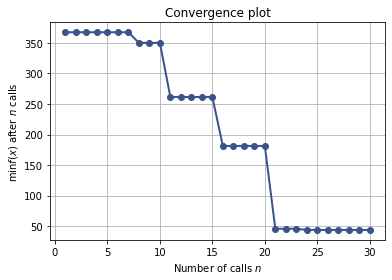

In [38]:
plot_convergence(search_result)

In [39]:
gp_results = pd.DataFrame(np.hstack([search_result.func_vals.reshape(-1,1), np.array(search_result.x_iters)])).sort_values(0)
gp_results.columns = ['metric', 'learning_rate', 'units', 'hidden', 'dropout', 'rate_var_units', 'rate_var_drop', 'activation']
gp_results['metric'] = gp_results['metric'].astype(np.float32)
gp_results = pd.concat([gp_results, pd.DataFrame(list_metrics_results)], axis=1)
gp_results = gp_results.sort_values('metric')

In [40]:
best_hp = gp_results.sort_values('metric').iloc[0, 1:8].to_dict()
best_hp['learning_rate'] = float(best_hp['learning_rate'])
best_hp['units'] = int(best_hp['units'])
best_hp['hidden'] = int(best_hp['hidden'])
best_hp['dropout'] = float(best_hp['dropout'])
best_hp['rate_var_units'] = float(best_hp['rate_var_units'])
best_hp['rate_var_drop'] = float(best_hp['rate_var_drop'])
print('best_hp: ', best_hp)
print('\nbest architecture:')
define_ffnn_model(input_shape, output_shape, best_hp).summary()


best_hp:  {'learning_rate': 0.1, 'units': 64, 'hidden': 1, 'dropout': 0.4, 'rate_var_units': 0.6, 'rate_var_drop': 0.8, 'activation': 'relu'}

best architecture:
Model: "model_163"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_164 (InputLayer)       [(None, 17)]              0         
_________________________________________________________________
dense_533 (Dense)            (None, 64)                1152      
_________________________________________________________________
activation_370 (Activation)  (None, 64)                0         
_________________________________________________________________
batch_normalization_370 (Bat (None, 64)                256       
_________________________________________________________________
dropout_370 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_534 (Dense)          

hyperparameters: {'learning_rate': 0.1, 'units': 64, 'hidden': 1, 'dropout': 0.4, 'rate_var_units': 0.6, 'rate_var_drop': 0.8, 'activation': 'relu'} 

Epoch 1/100
4/4 [==============================] - 1s 58ms/step - loss: 1401940.5000 - mse: 1401940.2500 - mae: 480.7984 - val_loss: 1273945.8750 - val_mse: 1273945.1250 - val_mae: 461.5639
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 1391974.2500 - mse: 1391973.3750 - mae: 475.0504 - val_loss: 1255166.3750 - val_mse: 1255165.1250 - val_mae: 450.6474
Epoch 3/100
4/4 [==============================] - 0s 8ms/step - loss: 1367661.2500 - mse: 1367659.8750 - mae: 463.4573 - val_loss: 1220517.7500 - val_mse: 1220515.8750 - val_mae: 434.6011
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 1324376.8750 - mse: 1324375.0000 - mae: 444.2488 - val_loss: 1170045.6250 - val_mse: 1170043.2500 - val_mae: 411.9188
Epoch 5/100
4/4 [==============================] - 0s 7ms/step - loss: 1256947.6250 - mse:

2022-05-17 20:15:50.411194: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


------------------------ 
rmse_train: 179.12683  mae_train: 60.7051
rmse_val: 193.44557  mae_val: 65.9821
------------------------ 


({'rmse': 179.12683, 'mae': 60.7051},
 {'rmse': 193.44557, 'mae': 65.9821},
 <keras.engine.functional.Functional at 0x7f75794d2310>)

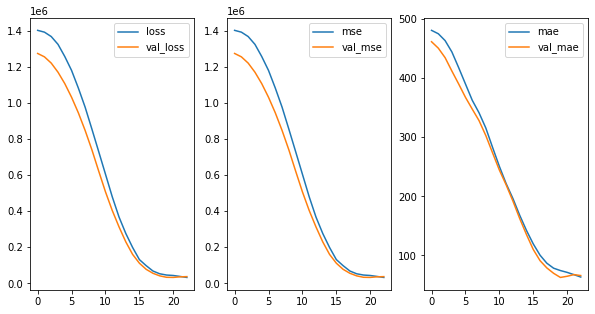

In [41]:
## evaluation over test
num_epochs = 100
print('hyperparameters:', best_hp, '\n')        
training_process(x_train, y_train, x_test, y_test, input_shape, output_shape, batch_size,
                 best_hp, is_evaluation=True)
